In [1]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
%matplotlib inline

In [2]:
from nmt_run import *

translating es to en
callhome es-en configuration
--------------------------------------------------
loading info_dict from=./fbank_out/info.dict


 35%|███▌      | 49098/138708 [00:00<00:00, 490973.44it/s]

--------------------------------------------------
creating buckets for: fisher_dev
creating buckets for key: sp
creating buckets for: fisher_dev2
creating buckets for key: sp
creating buckets for: fisher_test
creating buckets for key: sp
creating buckets for: fisher_train
creating buckets for key: sp


100%|██████████| 138708/138708 [00:00<00:00, 526621.97it/s]


--------------------------------------------------
saving info dict in: ./fbank_out/buckets_sp.dict
all done ...
--------------------------------------------------
showing buckets for category: fisher_dev
number of buckets=20, width of each bucket=96
index | width | num   
    0 |     0 |    428
    1 |    96 |    978
    2 |   192 |    566
    3 |   288 |    459
    4 |   384 |    337
    5 |   480 |    233
    6 |   576 |    230
    7 |   672 |    179
    8 |   768 |    149
    9 |   864 |    142
   10 |   960 |     79
   11 |  1056 |     85
   12 |  1152 |     45
   13 |  1248 |     28
   14 |  1344 |     24
   15 |  1440 |      7
   16 |  1536 |      5
   17 |  1632 |      1
   18 |  1728 |      1
   19 |  1824 |      1
--------------------------------------------------
showing buckets for category: fisher_dev2
number of buckets=20, width of each bucket=96
index | width | num   
    0 |     0 |    314
    1 |    96 |    879
    2 |   192 |    672
    3 |   288 |    506
    4 |   38

/afs/inf.ed.ac.uk/group/project/lowres/work/anaconda3/envs/chainer2/lib/python3.6/site-packages/chainer/utils/experimental.py:104: FutureWarning: chainer.links.normalization.layer_normalization.py is experimental. The interface can change in the future.
  FutureWarning)


using ADAM optimizer


In [3]:
model_files = [f for f in os.listdir(os.path.dirname(model_fil))
                   if os.path.basename(model_fil).replace('.model','') in f]
print(model_files)

['seq2seq_sen-138819_hwy0-dec3_emb-64-h-256__sp_en_w_gru_drpt-0.2_noise-0_l2-0_32_32_32_32_1_2_1_2_2DCNN_BN_LN_enc-3_10.model', 'seq2seq_sen-138819_hwy0-dec3_emb-64-h-256__sp_en_w_gru_drpt-0.2_noise-0_l2-0_32_32_32_32_1_2_1_2_2DCNN_BN_LN_enc-3_20.model', 'seq2seq_sen-138819_hwy0-dec3_emb-64-h-256__sp_en_w_gru_drpt-0.2_noise-0_l2-0_32_32_32_32_1_2_1_2_2DCNN_BN_LN_enc-3_30.model', 'seq2seq_sen-138819_hwy0-dec3_emb-64-h-256__sp_en_w_gru_drpt-0.2_noise-0_l2-0_32_32_32_32_1_2_1_2_2DCNN_BN_LN_enc-3_40.model']


In [4]:
max_model_fil = max(model_files, key=lambda s: int(s.split('_')[-1].split('.')[0]))

In [5]:
max_model_fil

'seq2seq_sen-138819_hwy0-dec3_emb-64-h-256__sp_en_w_gru_drpt-0.2_noise-0_l2-0_32_32_32_32_1_2_1_2_2DCNN_BN_LN_enc-3_40.model'

In [6]:
last_epoch = check_model()

--------------------------------------------------------------------------------
model found = 
fsh_fbank/seq2seq_sen-138819_hwy0-dec3_emb-64-h-256__sp_en_w_gru_drpt-0.2_noise-0_l2-0_32_32_32_32_1_2_1_2_2DCNN_BN_LN_enc-3_40.model
loading ...
finished loading ..


In [7]:
log_dev_fil_name

'fsh_fbank/dev_sen-138819_hwy0-dec3_emb-64-h-256__sp_en_w_gru_drpt-0.2_noise-0_l2-0_32_32_32_32_1_2_1_2_2DCNN_BN_LN_enc-3.log'

In [8]:
log_train = np.loadtxt(log_train_fil_name, delimiter=',', skiprows=False).transpose()
log_test = np.loadtxt(log_dev_fil_name, delimiter=',', skiprows=5).transpose()

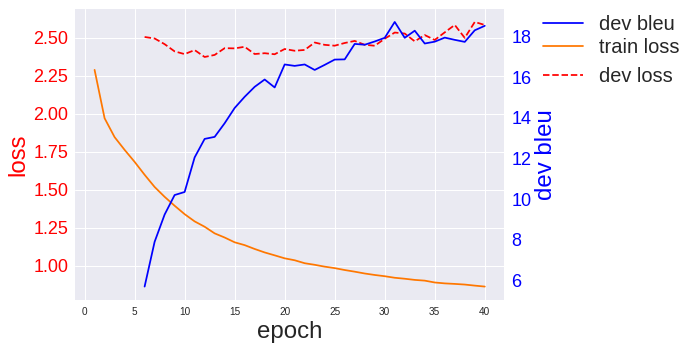

In [20]:
fig, ax1 = plt.subplots()
fig.set_size_inches(8,5)
ax1.plot(log_train[0], log_train[1], color='#ff7700')
ax1.plot(log_test[0], log_test[1], 'r--')
ax1.set_xlabel('epoch', size=24)
ax1.set_ylabel('loss', color='r', size=24)
for tl in ax1.get_yticklabels():
    tl.set_color('r')
    tl.set_fontsize(18)
plt.legend(['train loss', 'dev loss'], bbox_to_anchor=(1.45, 0.96), framealpha=0, fontsize=20)    
ax2 = ax1.twinx()
ax2.plot(log_test[0], log_test[2]*100, 'b-')
ax2.set_xlabel('iteration')
ax2.set_ylabel('dev bleu', color='b', size=24)
# ax2.set_ylim(0, 0.9)
for tl in ax2.get_yticklabels():
    tl.set_color('b')
    tl.set_fontsize(18) 
plt.legend(['dev bleu'], bbox_to_anchor=(1.44, 1.04), framealpha=0, fontsize=20)
plt.grid(False)
plt.tight_layout()

In [15]:
key='fisher_dev2'
train=False
m_dict = map_dict[key]
v_dict = vocab_dict[dec_key]
n=len(map_dict[key])

In [16]:
cat_speech_path = os.path.join(out_path, key)

In [17]:
print("-"*80)
print("EPOCH = {0:d}".format(last_epoch+1))
pred_sents, utts, loss = feed_model(map_dict[key],
                  b_dict=bucket_dict[key],
                  vocab_dict=vocab_dict,
                  batch_size=BATCH_SIZE,
                  x_key=enc_key,
                  y_key=dec_key,
                  train=train,
                  cat_speech_path=cat_speech_path, use_y=True)

print("{0:s} {1:s} mean loss={2:.4f}".format("*" * 10,
                                    "train" if train else "dev",
                                    loss))
print("-")
print("-"*80)

  0%|          | 0/3959 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
EPOCH = 41


b=4,l=2.36,avg=2.83: 100%|██████████| 3959/3959 [03:26<00:00,  4.25it/s] 

********** dev mean loss=2.8300
-
--------------------------------------------------------------------------------


In [18]:
display_words(m_dict, v_dict, pred_sents[-50:], utts[-50:], dec_key)

Utterance: 20050926_180516_125_fsp-A-116
+---------+---------------------------------------------+
| es ref  | ajá dice aquí al weather weather channel    |
+---------+---------------------------------------------+
| en ref  | yeah says it on the weather weather channel |
+---------+---------------------------------------------+
| en pred | aha alicia here i can return abroad         |
+---------+---------------------------------------------+
Utterance: 20050925_180713_120_fsp-B-104
+---------+----------------------------------------------+
| es ref  | claro claro como que uno se acostumbra y ya  |
+---------+----------------------------------------------+
| en ref  | of course of course like you get used to and |
|         | already                                      |
+---------+----------------------------------------------+
| en pred | sure sur like you get used to it and         |
+---------+----------------------------------------------+
Utterance: 20050910_210708_33_fsp-B-38
+

In [19]:
b, h, r = calc_bleu(m_dict, v_dict, pred_sents[:n], utts[:n], dec_key)
print("bleu score = {0:.2f}%".format(corpus_bleu(r, h) * 100))

bleu score = 18.66%
